In [283]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from zenrows import ZenRowsClient
client = ZenRowsClient("fa1a58c4dda65f20ad3ea8423dbe1b7ea3b0ced7")

In [179]:
def get_total_stats(webpage, stat):
    """
    Given a player's college stats page, returns the total stats for the player.
    """
    stat_html = webpage.select(f'td[data-stat="{stat}"]')
    if stat_html:
        return stat_html[-1].get_text()
    else:
        return None

In [292]:
# Loop over all years in the dataset.
current = False
START_YEAR = 2012
END_YEAR = 2023

STATS_LIST = [
    #Defense and Fumbles
    'tackles_solo',
    'tackles_assists',
    'tackles_total', 
    'tackles_loss',
    'sacks', 
    'def_int',
    'def_int_yds', 
    'def_int_td', 
    'pass_defended',
    'fumbles_rec', 
    'fumbles_rec_yds',
    'fumbles_rec_td',
    'fumbles_forced', 

    # Passing
    'pass_cmp', 
    'pass_att',
    'pass_cmp_pct',
    'pass_yds',
    'pass_td',
    'pass_int',
    'pass_rating',

    # Receiving & Rushing 
    'rec',
    'rec_yds',
    'rec_yds_per_rec',
    'rec_td',
    'rush_att',
    'rush_yds',
    'rush_yds_per_att',
    'rush_td',
    'scrim_att',
    'scrim_yds',
    'scrim_yds_per_att',
    'scrim_td',

    # Punt & Kick Returns 
    'punt_ret',
    'punt_ret_yds',
    'punt_ret_yds_per_ret',
    'punt_ret_td',
    'kick_ret',
    'kick_ret_yds',
    'kick_ret_yds_per_ret',
    'kick_ret_td'
    
    # Punting & Kicking
    'xpm',
    'xpa',
    'xp_pct',
    'fgm',
    'fga',
    'fg_pct',
    'kick_points',
    'punt',
    'punt_yds',
    'punt_yds_per_punt'
    ]


for year in range(START_YEAR, END_YEAR + 1):
    df = pd.DataFrame()
    print(year)
    # Read draft data
    url = f"https://www.pro-football-reference.com/draft/{year}-combine.htm"
    response = requests.get(url)
    webpage = BeautifulSoup(response.text, 'html.parser')
    # Get the names of the players
    names_html = webpage.select("tbody .left:nth-child(1)")
    all_names = [name.get_text() for name in names_html]
    names = [name for name in all_names if name != "Player"]
    num_players = len(names)

    # Get the position of the players
    pos_html = webpage.select("th+ td")
    pos = [pos.get_text() for pos in pos_html]
    pick = [0] * num_players
    round_ = [0] * num_players

    # Get draft data if this is not the current year.
    if not current:
        draft_html = webpage.select(".right+ .left")
        draft_info = [info.get_text() for info in draft_html]
        draft_info = ["Undrafted / 0th / 0th / 0" if info == "" else info for info in draft_info]
        draft_spots = [info.split(" / ") for info in draft_info]
        round_ = [int(spot[1][0]) for spot in draft_spots]
        pick = [int(''.join(filter(str.isdigit, spot[2]))) for spot in draft_spots]

    #Get school data
    college_elements = webpage.select('td.left + .left')
    college = [element.get_text() for element in college_elements]

    df["Name"] = names
    df["Position"] = pos
    df["College"] = college
    df["Round"] = round_
    df["Pick"] = pick
    
    # Get the links to the player's college stats
    stat_urls = []
    for link in webpage.select('td[data-stat="college"]'):
        if link.find('a'):
            stat_urls.append(link.find('a').get('href'))
        else:
            stat_urls.append(None)

    df["Stat URL"] = stat_urls

    # Get height
    height_html = webpage.select("td[data-stat='height']")
    height = [h.get_text() for h in height_html]
    height = [h.split("-") for h in height]
    new_height = []
    for h in height:
        if len(h) == 2:
            new_height.append((int(h[0]) * 12 + int(h[1])))
        else:
            new_height.append(math.nan)
    # height = [(int(h[0]) * 12 + int(h[1])) if h !="" else math.nan for h in height]
    df["Height"] = new_height

    # Get weight
    weight_html = webpage.select("td[data-stat='weight']")
    weight = [w.get_text() for w in weight_html]
    weight = [int(w) if w != "" else math.nan for w in weight]
    df["Weight"] = weight

    # Get 40 yard dash
    forty_html = webpage.select("td[data-stat='forty_yd']")
    forty = [f.get_text() for f in forty_html]
    forty = [float(f) if f != "" else math.nan for f in forty]  
    df["40 Yard Dash"] = forty

    # Get bench press
    bench_html = webpage.select("td[data-stat='bench_reps']")
    bench = [b.get_text() for b in bench_html]
    bench = [int(b) if b != "" else math.nan for b in bench]
    df["Bench Press"] = bench

    # Get vertical jump
    vertical_html = webpage.select("td[data-stat='vertical']")
    vertical = [v.get_text() for v in vertical_html]
    vertical = [float(v) if v != "" else math.nan for v in vertical]
    df["Vertical Jump"] = vertical

    # Get broad jump
    broad_html = webpage.select("td[data-stat='broad_jump']")
    broad = [b.get_text() for b in broad_html]
    broad = [int(b) if b != "" else math.nan for b in broad]
    df["Broad Jump"] = broad

    # Get 3 cone drill
    cone_html = webpage.select("td[data-stat='cone']")
    cone = [c.get_text() for c in cone_html]
    cone = [float(c) if c != "" else math.nan for c in cone]
    df["3 Cone Drill"] = cone

    # Get shuttle
    shuttle_html = webpage.select("td[data-stat='shuttle']")
    shuttle = [s.get_text() for s in shuttle_html]
    shuttle = [float(s) if s != "" else math.nan for s in shuttle]
    df["Shuttle"] = shuttle

    df.dropna(subset=["Stat URL"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    urls  = df["Stat URL"]
    all_stats = {}
    
    for url in tqdm(urls):
        stats = {}
        response = client.get(url)
        webpage = BeautifulSoup(response.text, 'html.parser')
        
        # Get conference from stat page
        conf_html = webpage.select('td[data-stat="conf_abbr"]')
        if conf_html:
            conf = conf_html[0].get_text()
            stats['conf_abbr'] = conf
        else:
            stats['conf_abbr'] = None

        # Get games played and seasons played
        games_html = webpage.select('td[data-stat="g"]')
        
        if games_html:
            season = 0
            games_played = 0
            for game in games_html:
                if game.get_text() != "":
                    games_played += int(game.get_text())
                    season += 1
            
            stats['games'] = games_played
            stats['seasons'] = season
        else:
            stats['games'] = None
            stats['seasons'] = None

        # Get total stats
        for stat in STATS_LIST:
            stats[stat] = get_total_stats(webpage, stat)

        all_stats[url] = stats

    stat_df = pd.DataFrame(all_stats).T
    stat_df.index.name = "Stat URL"
    new_df = pd.merge(df, stat_df, on="Stat URL")
    new_df["Year"] = year
    new_df.to_csv(f"data/{year}.csv", index=False)


2021
['6', '2']
['6', '1']
['6', '3']
['']
['5', '7']
['6', '4']
['6', '5']
['6', '6']
['5', '8']
['5', '8']
['6', '3']
['6', '0']
['6', '7']
['6', '5']
['6', '1']
['6', '4']
['6', '0']
['6', '3']
['6', '0']
['6', '5']
['5', '11']
['5', '10']
['6', '3']
['6', '4']
['6', '2']
['5', '9']
['']
['6', '4']
['5', '11']
['6', '0']
['5', '9']
['6', '0']
['6', '5']
['5', '11']
['6', '5']
['6', '3']
['5', '11']
['5', '10']
['6', '0']
['6', '2']
['5', '10']
['6', '4']
['5', '11']
['6', '3']
['6', '0']
['5', '9']
['5', '9']
['5', '11']
['6', '2']
['6', '2']
['6', '1']
['5', '10']
['5', '11']
['5', '9']
['6', '5']
['6', '0']
['6', '1']
['6', '4']
['6', '2']
['6', '1']
['6', '0']
['6', '4']
['6', '0']
['5', '7']
['6', '2']
['6', '0']
['6', '1']
['6', '2']
['']
['']
['5', '9']
['6', '6']
['6', '2']
['6', '4']
['6', '4']
['6', '2']
['6', '2']
['6', '5']
['5', '11']
['6', '3']
['6', '2']
['6', '1']
['6', '1']
['6', '1']
['5', '9']
['6', '2']
['6', '5']
['6', '1']
['6', '3']
['5', '11']
['6', '0']
['5',

100%|██████████| 456/456 [00:22<00:00, 20.69it/s]


2022
['6', '2']
['6', '8']
['6', '6']
['6', '4']
['5', '11']
['6', '4']
['6', '2']
['6', '6']
['6', '1']
['6', '1']
['6', '0']
['5', '8']
['5', '8']
['6', '0']
['6', '5']
['6', '4']
['6', '2']
['6', '1']
['5', '11']
['6', '5']
['6', '1']
['6', '1']
['6', '2']
['5', '11']
['6', '3']
['6', '3']
['6', '0']
['5', '9']
['6', '1']
['6', '2']
['5', '11']
['6', '5']
['6', '0']
['6', '0']
['6', '5']
['6', '1']
['6', '4']
['6', '2']
['5', '10']
['6', '4']
['6', '0']
['6', '4']
['6', '1']
['6', '2']
['6', '3']
['6', '4']
['6', '1']
['5', '11']
['6', '3']
['6', '2']
['6', '3']
['6', '5']
['6', '3']
['6', '0']
['5', '10']
['6', '1']
['5', '11']
['5', '11']
['6', '0']
['6', '2']
['6', '5']
['6', '0']
['6', '1']
['6', '5']
['6', '3']
['6', '6']
['6', '1']
['6', '0']
['5', '11']
['6', '6']
['6', '5']
['6', '1']
['6', '7']
['6', '3']
['6', '1']
['5', '11']
['6', '2']
['6', '1']
['6', '4']
['6', '5']
['5', '10']
['5', '8']
['6', '2']
['5', '11']
['6', '4']
['6', '2']
['6', '1']
['6', '4']
['6', '2']
['6

100%|██████████| 299/299 [00:13<00:00, 21.59it/s]


2023
['5', '10']
['6', '1']
['5', '9']
['5', '11']
['6', '2']
['6', '4']
['6', '6']
['6', '3']
['6', '3']
['6', '3']
['6', '6']
['6', '1']
['6', '4']
['6', '3']
['6', '6']
['6', '4']
['6', '0']
['6', '1']
['6', '2']
['6', '1']
['6', '4']
['6', '1']
['6', '4']
['6', '0']
['5', '11']
['5', '11']
['6', '4']
['6', '5']
['6', '0']
['5', '11']
['6', '4']
['5', '11']
['6', '2']
['6', '4']
['6', '0']
['6', '3']
['6', '6']
['6', '4']
['6', '5']
['6', '1']
['6', '1']
['6', '0']
['5', '10']
['5', '11']
['5', '10']
['6', '2']
['6', '0']
['6', '5']
['6', '5']
['6', '3']
['6', '0']
['5', '10']
['6', '4']
['6', '2']
['6', '0']
['5', '11']
['6', '4']
['6', '0']
['6', '6']
['6', '1']
['6', '4']
['5', '8']
['5', '8']
['6', '1']
['6', '6']
['6', '3']
['5', '8']
['5', '9']
['6', '2']
['6', '2']
['6', '6']
['5', '8']
['6', '6']
['5', '10']
['6', '4']
['5', '10']
['5', '11']
['5', '9']
['6', '1']
['6', '4']
['6', '4']
['6', '5']
['6', '8']
['6', '4']
['6', '7']
['6', '2']
['6', '6']
['5', '9']
['6', '6']
['

100%|██████████| 284/284 [00:13<00:00, 21.37it/s]


In [4]:
# merging all data and storing in a file named training data
import pandas as pd

# List of file names
file_names = []
for year in range(2012, 2022):
    file_names.append(f"data/{year}.csv")

# Create an empty list to store DataFrames
dfs = []

# Read and append each file to the list
for file in file_names:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames
merged_df = pd.concat(dfs, ignore_index=True)

# Export the DataFrame to a CSV file
merged_df.to_csv("data/training.csv", index=False)

print("Data successfully saved to training.csv")


Data successfully saved to training.csv


Mean Height: 73.65
Mode Height: 75.0
Median Height: 74.0


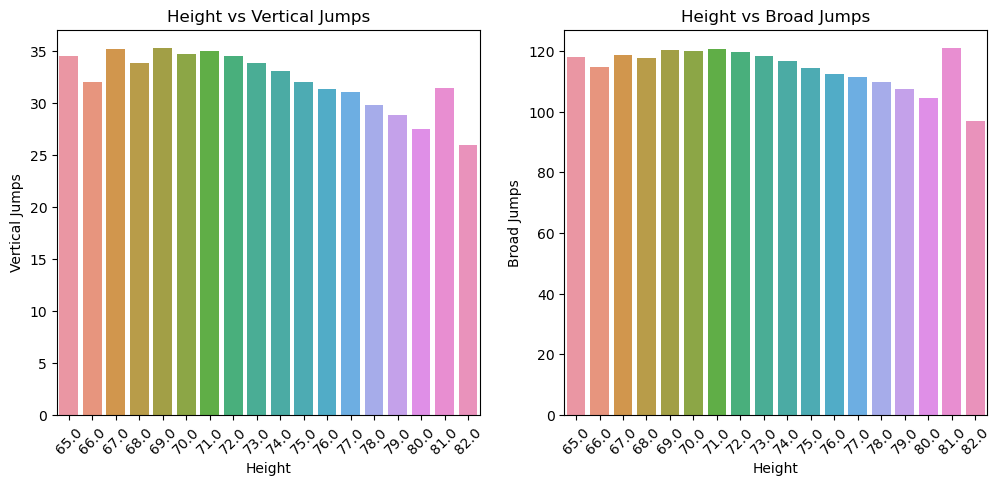

In [32]:
# Run descriptive statistics on the data and develop ideas on what to explore
# your code here
# [your code here]
#HINTS
import seaborn as sns
import matplotlib.pyplot as plt

org_df = pd.read_csv("data/training.csv")
df_VJ = org_df[["Height","Vertical Jump"]].copy()
df_BJ = org_df[["Height","Broad Jump"]].copy()

df_VJ = df_VJ.dropna(subset=["Vertical Jump"])
df_BJ = df_BJ.dropna(subset=["Broad Jump"])

# Calculate mean, mode, and median height
mean_height = df_VJ['Height'].mean()
mode_height = df_VJ['Height'].mode().iloc[0]  # Mode can have multiple values, so we select the first one
median_height = df_VJ['Height'].median()

# Print the numerical values of mean, mode, and median height
print(f"Mean Height: {mean_height:.2f}")
print(f"Mode Height: {mode_height}")
print(f"Median Height: {median_height}")

#Getting average vertial jump for a given height
grouped_df_VJ = df_VJ.groupby('Height').mean().reset_index()

#Getting average broad jump for a given height
grouped_df_BJ = df_BJ.groupby('Height').mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=grouped_df_VJ, x='Height', y='Vertical Jump', ax=axs[0])
axs[0].set_xlabel('Height')
axs[0].set_ylabel('Vertical Jumps')
axs[0].set_title('Height vs Vertical Jumps')
axs[0].tick_params(axis='x', rotation=45) 

sns.barplot(data=grouped_df_BJ, x='Height', y='Broad Jump', ax=axs[1])
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Broad Jumps')
axs[1].set_title('Height vs Broad Jumps')
axs[1].tick_params(axis='x', rotation=45) 

# Show plot
plt.show()


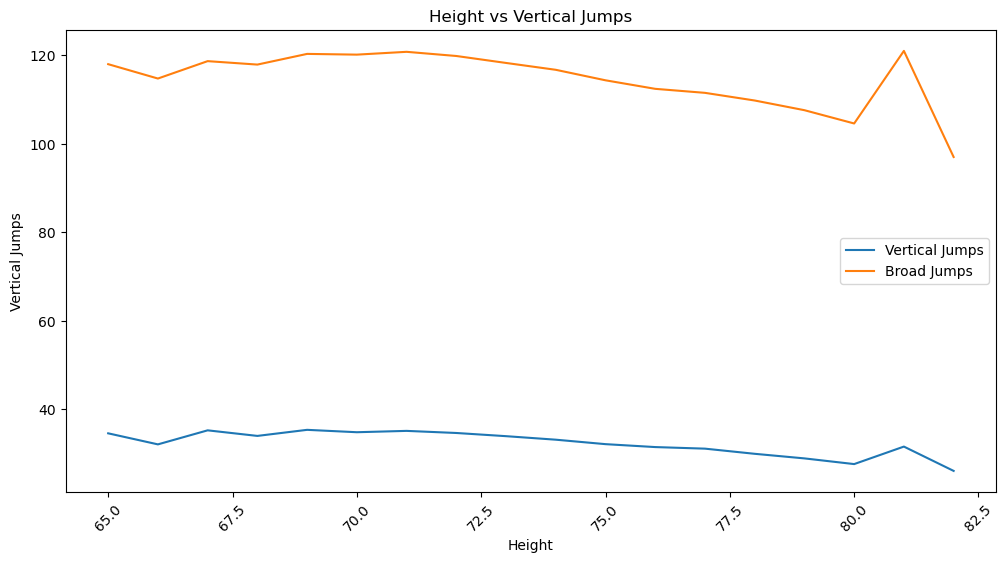

In [39]:

fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the line plot
sns.lineplot(data=grouped_df_VJ, x='Height', y='Vertical Jump', ax=ax, label='Vertical Jumps')

# Plotting the scatter plot
sns.lineplot(data=grouped_df_BJ, x='Height', y='Broad Jump', ax=ax, label='Broad Jumps')

# Adding labels and title
ax.set_xlabel('Height')
ax.set_ylabel('Vertical Jumps')
ax.set_title('Height vs Vertical Jumps')

# Rotate x-axis tick labels
ax.tick_params(axis='x', rotation=45)

# Show legend
ax.legend()

# Show plot
plt.show()


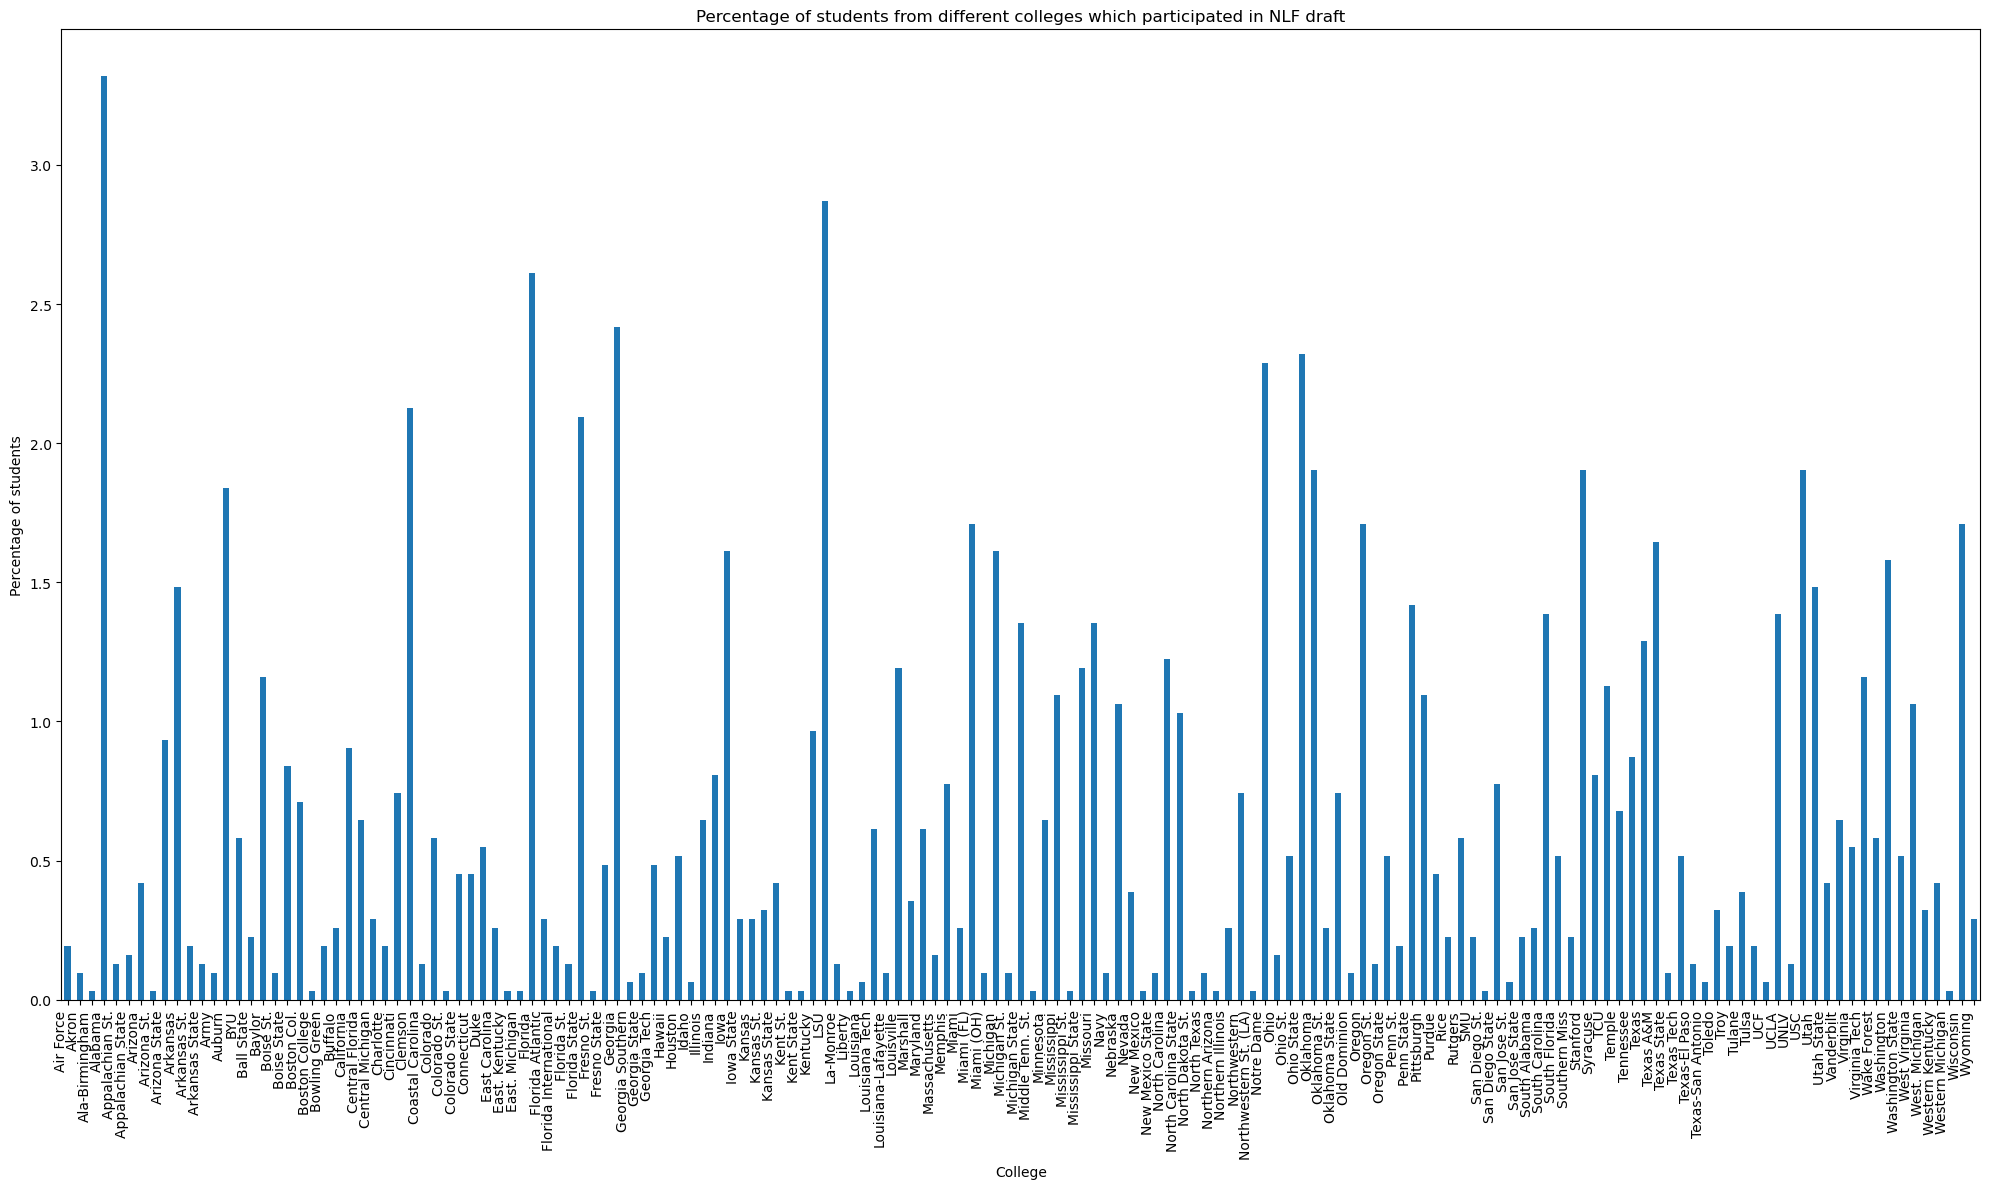

In [56]:
# Run descriptive statistics on the data and develop ideas on what to explore
# your code here
# [your code here]
#HINTS

df_college = org_df[["College"]].copy()

df_college = df_college.dropna(subset=["College"])

#Getting average vertial jump for a given height
grouped_df_college = df_college.groupby('College').size()
total = df_college.shape[0]
percentage_values = (grouped_df_college / total) * 100

# print(percentage_values)

plt.figure(figsize=(20, 12))
percentage_values.plot(kind='bar')
plt.title('Percentage of students from different colleges which participated in NLF draft')
plt.xlabel('College')
plt.ylabel('Percentage of students')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show plot
plt.show()
